In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

# Parameters
a, b, c = 0.5, 0.7, 0.2
yaw, pitch, roll = 30, 20, 45  # degrees
r = 0.62  # target sphere radius

# Sample 3D points near ellipsoid surface
theta = torch.rand(500) * 2 * torch.pi
phi = torch.acos(2 * torch.rand(500) - 1)
x = a * torch.sin(phi) * torch.cos(theta)
y = b * torch.sin(phi) * torch.sin(theta)
z = c * torch.cos(phi)
points = torch.stack([x, y, z]) + 0.1 * torch.randn(3, 500)

def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles
    return torch.tensor([
        [torch.cos(alpha)*torch.cos(beta), torch.cos(alpha)*torch.sin(beta)*torch.sin(gamma)-torch.sin(alpha)*torch.cos(gamma), torch.cos(alpha)*torch.sin(beta)*torch.cos(gamma)+torch.sin(alpha)*torch.sin(gamma)],
        [torch.sin(alpha)*torch.cos(beta), torch.sin(alpha)*torch.sin(beta)*torch.sin(gamma)+torch.cos(alpha)*torch.cos(gamma), torch.sin(alpha)*torch.sin(beta)*torch.cos(gamma)-torch.cos(alpha)*torch.sin(gamma)],
        [-torch.sin(beta), torch.cos(beta)*torch.sin(gamma), torch.cos(beta)*torch.cos(gamma)]
    ], dtype=torch.double)

def plot_ellipsoid_with_points(a, b, c, yaw, pitch, roll, points, r=0.62, vmin=None, vmax=None, show_gt=True):
    u = torch.linspace(0, 2 * torch.pi, 80)
    v = torch.linspace(0, torch.pi, 40)
    u, v = torch.meshgrid(u, v, indexing="ij")

    x = a * torch.cos(u) * torch.sin(v)
    y = b * torch.sin(u) * torch.sin(v)
    z = c * torch.cos(v)
    ellipsoid = torch.stack((x, y, z), dim=-1).reshape(-1, 3).T  # (3, N)

    angles_rad = torch.deg2rad(torch.tensor([yaw, pitch, roll]))
    R = rotation_matrix_3d(angles_rad)
    rotated = (R @ ellipsoid.double()).T.reshape(x.shape + (3,))
    ellipsoid_xyz = rotated.reshape(-1, 3).T
    surface_dist = torch.norm(ellipsoid_xyz, dim=0) - r
    residuals = surface_dist.reshape(rotated.shape[:2])

    # Normalize residuals for coloring
    # vmin, vmax = -2, 2
    if vmin is None or vmax is None:
        vmin, vmax = residuals.min().item(), residuals.max().item()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.colormaps["RdBu_r"]
    facecolors = cmap(norm(residuals))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        rotated[..., 0], rotated[..., 1], rotated[..., 2],
        facecolors=facecolors,
        rstride=1, cstride=1,
        antialiased=True, linewidth=0,
        alpha=0.8, shade=False
    )

    # Rotate points to align with ellipsoid
    points = (R @ points.double()).detach()
    ax.scatter(points[0], points[1], points[2], s=1, alpha=0.3, color="black")
    ax.set_axis_off()
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
    ax.set_box_aspect([1, 1, 1])

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])
    fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1, label="Residual from sphere (r=0.62)")
    if show_gt:
        u_gt = torch.linspace(0, 2 * torch.pi, 40)
        v_gt = torch.linspace(0, torch.pi, 20)
        u_gt, v_gt = torch.meshgrid(u_gt, v_gt, indexing="ij")
        x_gt = r * torch.cos(u_gt) * torch.sin(v_gt)
        y_gt = r * torch.sin(u_gt) * torch.sin(v_gt)
        z_gt = r * torch.cos(v_gt)

        ax.plot_surface(
            x_gt, y_gt, z_gt,
            color="gray", alpha=0.05
        )

    plt.show()
    return fig

# Call it


In [ ]:
plot_ellipsoid_with_points(a, b, c, yaw, pitch, roll, points, r=0.62)
# plt.show()


In [ ]:
import plotly.graph_objects as go

def plot_ellipsoid_plotly(a, b, c, yaw, pitch, roll, points, r=0.62, show_gt=True):
    u, v = torch.linspace(0, 2 * torch.pi, 80), torch.linspace(0, torch.pi, 40)
    u, v = torch.meshgrid(u, v, indexing="ij")
    x = a * torch.cos(u) * torch.sin(v)
    y = b * torch.sin(u) * torch.sin(v)
    z = c * torch.cos(v)

    # Rotation
    angles = torch.tensor([yaw, pitch, roll])
    R = rotation_matrix_3d(torch.deg2rad(angles))
    ellipsoid = torch.stack([x, y, z], dim=-1).reshape(-1, 3).T.double()  # (3, N)
    rotated = (R @ ellipsoid).T.reshape(x.shape + (3,))

    # Residuals for color
    ellipsoid_xyz = rotated.reshape(-1, 3).T
    radii = torch.norm(ellipsoid_xyz, dim=0)
    residuals = (radii - r).reshape(rotated.shape[:2]).cpu().numpy()

    surface = go.Surface(
        x=rotated[..., 0].cpu().numpy(),
        y=rotated[..., 1].cpu().numpy(),
        z=rotated[..., 2].cpu().numpy(),
        surfacecolor=residuals,
        colorscale='RdBu',
        cmin=-0.5,
        cmax=0.5,
        opacity=0.99,
        showscale=True
    )

    # Noisy points (rotated)
    pts = (R @ points.double()).detach().cpu().numpy()/3
    scatter = go.Scatter3d(
        x=pts[0], y=pts[1], z=pts[2],
        mode='markers',
        marker=dict(size=1, color='black', opacity=0.3)
    )

    # Optional: GT sphere wireframe
    if show_gt:
        u_gt, v_gt = torch.meshgrid(torch.linspace(0, 2*torch.pi, 40), torch.linspace(0, torch.pi, 20))
        x_gt = r * torch.cos(u_gt) * torch.sin(v_gt)
        y_gt = r * torch.sin(u_gt) * torch.sin(v_gt)
        z_gt = r * torch.cos(v_gt)
        sphere = go.Surface(
            x=x_gt, y=y_gt, z=z_gt,
            showscale=False,
            opacity=0.1,
            colorscale=[[0, "gray"], [1, "gray"]],
            surfacecolor=torch.zeros_like(x_gt)
        )
        data = [surface, scatter, sphere]
    else:
        data = [surface, scatter]

    fig = go.Figure(data=data)
    fig.update_layout(scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ))
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible=False),
            yaxis = dict(visible=False),
            zaxis =dict(visible=False)
            )
        )
    return fig
fig = plot_ellipsoid_plotly(a, b, c, yaw, pitch, roll, points, r=0.62, show_gt=False)
fig.show()

In [ ]:
import torch
import torch.nn.functional as F

def angles_from_normal(normal: torch.Tensor):
    """
    Convert a normal vector to Euler angles (yaw, pitch, roll=0)
    so that rotating the camera forward axis [0,0,1] gives the normal.
    """
    x, y, z = normal.unbind(-1)

    # yaw = azimuth angle in xy-plane
    yaw = torch.atan2(y, x)
    
    # pitch = angle from z axis
    xy_len = torch.sqrt(x**2 + y**2)
    pitch = torch.atan2(z, xy_len)

    roll = torch.zeros_like(yaw)
    return torch.stack([yaw, pitch, roll], dim=-1)  # in radians
def rotation_matrix_zyx(angles):
    """
    Create rotation matrix from Euler angles in radians (yaw, pitch, roll),
    using ZYX (yaw → pitch → roll) convention.
    """
    yaw, pitch, roll = angles.unbind(-1)
    cy, cp, cr = torch.cos(yaw), torch.cos(pitch), torch.cos(roll)
    sy, sp, sr = torch.sin(yaw), torch.sin(pitch), torch.sin(roll)

    R = torch.stack([
        torch.stack([cy * cp, cy * sp * sr - sy * cr, cy * sp * cr + sy * sr], dim=-1),
        torch.stack([sy * cp, sy * sp * sr + cy * cr, sy * sp * cr - cy * sr], dim=-1),
        torch.stack([-sp,     cp * sr,                cp * cr], dim=-1)
    ], dim=-2)  # shape (..., 3, 3)

    return R
normals = F.normalize(torch.tensor([
    [1.0, 1.0, 1.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
]), dim=1)

def build_rotation_from_normal(n: torch.Tensor):
    """
    Given a normal vector, construct a rotation matrix where:
    - the third row is the normal
    - the first two rows are orthonormal in-plane directions
    - no roll is applied
    """
    z = F.normalize(n, dim=0)
    tmp = torch.tensor([0.0, 0.0, 1.0], dtype=z.dtype)
    if torch.allclose(z, tmp):
        tmp = torch.tensor([1.0, 0.0, 0.0], dtype=z.dtype)
    x = F.normalize(torch.cross(tmp, z), dim=0)
    y = torch.cross(z, x)
    return torch.stack([x, y, z], dim=0)  # Shape: (3, 3)

R_stack = torch.stack([build_rotation_from_normal(n) for n in normals])
recovered_dirs = R_stack[:, 2, :]

print("Recovered:\n", recovered_dirs)
print("Original:\n", normals)
print("Match?", torch.allclose(recovered_dirs, normals, atol=1e-5))


In [ ]:
def euler_angles_from_matrix(R: torch.Tensor):
    """
    Extract yaw, pitch, roll from a rotation matrix using ZYX convention.
    Input R: Tensor of shape (3, 3)
    Returns angles: Tensor of shape (3,) in radians: [yaw, pitch, roll]
    """
    pitch = -torch.arcsin(R[2, 0])  # R[2,0] = -sin(pitch)
    cp = torch.cos(pitch)
    if torch.isclose(cp, torch.tensor(0.0)):
        # Gimbal lock case: pitch = ±90°
        yaw = torch.atan2(-R[0, 1], R[1, 1])
        roll = torch.tensor(0.0)  # Arbitrary
    else:
        roll = torch.atan2(R[2, 1] / cp, R[2, 2] / cp)
        yaw  = torch.atan2(R[1, 0] / cp, R[0, 0] / cp)

    return torch.stack([yaw, pitch, roll])
def batch_euler_angles_from_matrix(Rs: torch.Tensor):
    """
    Input: Rs of shape (N, 3, 3)
    Output: angles of shape (N, 3) in radians
    """
    return torch.stack([euler_angles_from_matrix(R) for R in Rs], dim=0)
R1 = torch.stack([build_rotation_from_normal(n) for n in normals])  # True rotation
angles = batch_euler_angles_from_matrix(R1)                         # Extracted
R2 = rotation_matrix_3d_batch(angles)                               # Reconstructed

print("Match?", torch.allclose(R1, R2, atol=1e-5))
R1, R2


In [ ]:
from torch import cos, sin

def generate_test_points():
    # Unit cube corners for easy visualization
    from itertools import product
    pts = torch.tensor(list(product([-1, 1], repeat=3)), dtype=torch.float)  # (8, 3)
    return pts  # Shape: (8, 3)
def apply_rotation(R: torch.Tensor, pts: torch.Tensor):
    """
    R: (3, 3) rotation matrix
    pts: (N, 3) points
    Returns: rotated points (N, 3)
    """
    return pts @ R.T
def compare_transformations(R1, R2):
    pts = generate_test_points()
    pts1 = apply_rotation(R1, pts)
    pts2 = apply_rotation(R2, pts)
    
    diff = torch.norm(pts1 - pts2, dim=1)
    print("Pointwise differences:", diff)
    print("Max diff:", diff.max())
    return torch.allclose(pts1, pts2, atol=1e-5)
def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles[0], angles[1], angles[2]
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)]),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)]),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)])
    ])
    return R

# Build rotation matrix from normal
normal = F.normalize(torch.tensor([1.0, 1.0, 1.0]), dim=0)
R1 = build_rotation_from_normal(normal)

# Extract angles, rebuild matrix
angles = euler_angles_from_matrix(R1)
R2 = rotation_matrix_3d(angles)

# Compare transformation effects
compare_transformations(R1, R2)


In [ ]:
import torch
import torch.nn.functional as F
from itertools import product

# --- Rotation utilities ---

def build_rotation_from_normal(n: torch.Tensor):
    z = F.normalize(n, dim=0)
    tmp = torch.tensor([0.0, 0.0, 1.0], dtype=z.dtype)
    if torch.allclose(z, tmp):
        tmp = torch.tensor([1.0, 0.0, 0.0], dtype=z.dtype)
    x = F.normalize(torch.cross(tmp, z), dim=0)
    y = torch.cross(z, x)
    return torch.stack([x, y, z], dim=0)  # Shape: (3, 3)

def batch_rotation_from_normals(normals):
    return torch.stack([build_rotation_from_normal(n) for n in normals])

def rotation_matrix_3d(angles):
    yaw, pitch, roll = angles.unbind(-1)
    cy, cp, cr = torch.cos(yaw), torch.cos(pitch), torch.cos(roll)
    sy, sp, sr = torch.sin(yaw), torch.sin(pitch), torch.sin(roll)
    R = torch.stack([
        torch.stack([cy * cp, cy * sp * sr - sy * cr, cy * sp * cr + sy * sr], dim=-1),
        torch.stack([sy * cp, sy * sp * sr + cy * cr, sy * sp * cr - cy * sr], dim=-1),
        torch.stack([-sp, cp * sr, cp * cr], dim=-1)
    ], dim=-2)
    return R

def euler_angles_from_matrix(R: torch.Tensor):
    pitch = -torch.arcsin(R[2, 0])
    cp = torch.cos(pitch)
    if torch.isclose(cp, torch.tensor(0.0, dtype=R.dtype)):
        yaw = torch.atan2(-R[0, 1], R[1, 1])
        roll = torch.tensor(0.0, dtype=R.dtype)
    else:
        roll = torch.atan2(R[2, 1] / cp, R[2, 2] / cp)
        yaw = torch.atan2(R[1, 0] / cp, R[0, 0] / cp)
    return torch.stack([yaw, pitch, roll])

def batch_euler_angles_from_matrix(Rs: torch.Tensor):
    return torch.stack([euler_angles_from_matrix(R) for R in Rs], dim=0)

def generate_test_points():
    pts = torch.tensor(list(product([-1, 1], repeat=3)), dtype=torch.double)
    return pts  # (8, 3)

def apply_rotation(R: torch.Tensor, pts: torch.Tensor):
    return pts @ R.T

def compare_transformations_batch(R1, R2):
    pts = generate_test_points()
    transformed1 = torch.stack([apply_rotation(R, pts) for R in R1])
    transformed2 = torch.stack([apply_rotation(R, pts) for R in R2])
    diffs = torch.norm(transformed1 - transformed2, dim=-1).max(dim=-1).values
    return diffs

# --- Test on provided normals ---

normals = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],       
    [0, 0, 1],       
    [1, 1, 1],
    [1, -1, 1], 
    [-1, 1, 1],
    [-1, -1, 1],
], dtype=torch.double)
normals = F.normalize(normals, dim=1)

R1 = batch_rotation_from_normals(normals)
angles = batch_euler_angles_from_matrix(R1)
R2 = rotation_matrix_3d(angles)



# Compare transformations
max_diffs = compare_transformations_batch(R1, R2)
max_diffs
angles = torch.rad2deg(angles)
angles

In [ ]:
rotation_matrix_3d(angles[4])

In [ ]:
rotation_matrix_3d(angles[5])

In [ ]:
torch.rad2deg(batch_euler_angles_from_matrix(R2))


In [ ]:
import torch
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl
# Ellipsoid parameters
a, b, c = 0.2, 0.2, 0.3
yaw, pitch, roll = 0., 0., 0.
m = 1600
sqrt_m = int(math.sqrt(m))

# Uniform sampler (ground truth)
def sample_ellipsoid_uniform(sqrt_m, a, b, c):
    def ellipsoid_func(theta, phi):
        x = a * torch.sin(theta) * torch.cos(phi)
        y = b * torch.sin(theta) * torch.sin(phi)
        z = c * torch.cos(theta)
        return torch.stack([x, y, z], dim=0)

    theta = torch.linspace(0, math.pi, sqrt_m).double()
    phi = torch.linspace(0, 2 * math.pi, sqrt_m).double()
    theta, phi = torch.meshgrid(theta, phi, indexing='ij')
    coords = ellipsoid_func(theta, phi).reshape(3, -1)
    return coords

# Rejection-based uniform method
def sample_ellipsoid_surface(sqrt_m, a, b, c):
    m = sqrt_m * sqrt_m
    samples = []
    while sum(s.numel() for s in samples) < m:
        n = (m - sum(s.numel() for s in samples)) * 3
        u = 2*torch.rand(n) - 1
        phi = 2*math.pi * torch.rand(n)
        theta = torch.acos(u)
        sin_theta = torch.sin(theta)
        cos_theta = u
        x = a * sin_theta * torch.cos(phi)
        y = b * sin_theta * torch.sin(phi)
        z = c * cos_theta
        w = torch.sqrt((sin_theta * torch.cos(phi) / a)**2 +
                       (sin_theta * torch.sin(phi) / b)**2 +
                       (cos_theta / c)**2)
        accept = torch.rand_like(w) < (w * min(a, b, c))
        if accept.any():
            pts = torch.stack([x[accept], y[accept], z[accept]], dim=0)
            samples.append(pts)
    coords = torch.cat(samples, dim=1)[:, :m].double()
    return coords

# Generate point clouds
P_true = sample_ellipsoid_uniform(sqrt_m, a, b, c)
P_old  = sample_ellipsoid_surface(sqrt_m, a, b, c)

# Visual comparison
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(P_true[0], P_true[1], P_true[2], s=1)
ax1.set_title('True Uniform Sampling')
ax1.set_aspect("equal")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(P_old[0], P_old[1], P_old[2], s=1)
ax2.set_title('Rejection-Based Sampling')
ax2.set_aspect("equal")

plt.tight_layout()
plt.show()


In [ ]:
from torch.nn.functional import pairwise_distance

P_true_c = P_true - P_true.mean(dim=1, keepdim=True)
P_old_c  = P_old  - P_old .mean(dim=1, keepdim=True)

# k-d tree substitute: brute force for a few thousand points
d = torch.cdist(P_true_c.T[:4000], P_old_c.T[:4000]).min(dim=1).values
print(d.mean().item(), "average NN distance (should be ≪ min(a,b,c))")


In [ ]:
# Re-import libraries after kernel reset
import torch
import math
import matplotlib.pyplot as plt

# Ellipsoid parameters
a, b, c = 0.2, 0.2, 0.3
sqrt_m = 40
noise_std = 0.0
yaw, pitch, roll = 0., 0., 0.

# Dummy rotation function (identity matrix)
def rotation_matrix_3d(angles):
    return torch.eye(3, dtype=torch.double)

# Provided r_surface sampler
def r_surface(n, func, t0, t1, u0, u1, t_precision=50, u_precision=50):
    theta_vals = torch.linspace(t0, t1, t_precision).double()
    phi_vals = torch.linspace(u0, u1, u_precision).double()
    theta, phi = torch.meshgrid(theta_vals, phi_vals, indexing='ij')
    coords = func(theta, phi)
    dt = torch.zeros_like(coords)
    du = torch.zeros_like(coords)
    dt[:, 1:, :] = coords[:, 1:, :] - coords[:, :-1, :]
    du[:, :, 1:] = coords[:, :, 1:] - coords[:, :, :-1]
    dS = torch.norm(torch.cross(dt, du, dim=0), dim=0)
    cum_S_t = torch.cumsum(dS.sum(dim=1), dim=0)
    cum_S_u = torch.cumsum(dS.sum(dim=0), dim=0)
    rand_S_t = torch.rand(n) * cum_S_t[-1]
    rand_S_u = torch.rand(n) * cum_S_u[-1]

    def interp(x, xp, fp):
        idx = torch.searchsorted(xp, x, right=True).clamp(min=1, max=len(xp) - 1)
        x0, x1 = xp[idx - 1], xp[idx]
        y0, y1 = fp[idx - 1], fp[idx]
        return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

    rand_theta = interp(rand_S_t, cum_S_t, theta_vals)
    rand_phi = interp(rand_S_u, cum_S_u, phi_vals)

    return func(rand_theta, rand_phi)

# Main sampling function
def sample_ellipsoid_surface(sqrt_m, a, b, c, yaw, pitch, roll, noise_std=1e-4, uniform=True):
    if uniform:
        m = sqrt_m * sqrt_m
        def ellipsoid_func(t, u):
            x = a * torch.sin(t) * torch.cos(u)
            y = b * torch.sin(t) * torch.sin(u)
            z = c * torch.cos(t)
            return torch.stack([x, y, z], dim=0)
        coords = r_surface(m, ellipsoid_func, 0, torch.pi, 0, 2*torch.pi, 100, 100)
    else:
        phi = 2.0 * math.pi * torch.linspace(0.0, 1.0, sqrt_m).double()
        theta = math.pi * torch.linspace(0.0, 1.0, sqrt_m).double()
        phi, theta = torch.meshgrid(phi, theta, indexing='ij')
        x = a * torch.sin(theta) * torch.cos(phi)
        y = b * torch.sin(theta) * torch.sin(phi)
        z = c * torch.cos(theta)
        coords = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=0)

    angles = torch.tensor([yaw, pitch, roll], dtype=torch.double)
    if torch.any(angles != 0):
        R = rotation_matrix_3d(torch.tensor([yaw, pitch, roll]))
        coords = R @ coords
    noisy = coords + noise_std * torch.randn_like(coords)
    return noisy.unsqueeze(0)

# Generate both samples
P_uniform = sample_ellipsoid_surface(sqrt_m, a, b, c, yaw, pitch, roll, noise_std, uniform=True)[0]
P_grid    = sample_ellipsoid_surface(sqrt_m, a, b, c, yaw, pitch, roll, noise_std, uniform=False)[0]

# Plotting
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(P_uniform[0], P_uniform[1], P_uniform[2], s=2)
ax1.set_title('Uniform Sampling (r_surface)')
ax1.set_aspect("equal")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(P_grid[0], P_grid[1], P_grid[2], s=2)
ax2.set_title('Non-uniform Grid Sampling')
ax2.set_aspect("equal")

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_ellipsoid_plotly(a, b, c, yaw, pitch, roll, points, r=0.62, vmin=None, vmax=None, show_gt=False):
    u, v = torch.linspace(0, 2 * torch.pi, 60), torch.linspace(0, torch.pi, 30)
    u, v = torch.meshgrid(u, v, indexing="ij")
    x = a * torch.cos(u) * torch.sin(v)
    y = b * torch.sin(u) * torch.sin(v)
    z = c * torch.cos(v)

    # Rotation
    angles = torch.tensor([yaw, pitch, roll],dtype=torch.double)
    R = rotation_matrix_3d(torch.deg2rad(angles))
    ellipsoid = torch.stack([x, y, z], dim=-1).reshape(-1, 3).T.double()  # (3, N)
    rotated = (R @ ellipsoid).T.reshape(x.shape + (3,))

    # Residuals for color
    ellipsoid_xyz = rotated.reshape(-1, 3).T
    radii = torch.norm(ellipsoid_xyz, dim=0)
    residuals = (radii - r).reshape(rotated.shape[:2]).cpu().numpy()
    if vmin is None or vmax is None:
        absmax = np.abs(residuals).max().item()
        vmin, vmax = -absmax, absmax

    surface = go.Surface(
        x=rotated[..., 0].cpu().numpy(),
        y=rotated[..., 1].cpu().numpy(),
        z=rotated[..., 2].cpu().numpy(),
        surfacecolor=residuals,
        colorscale='RdBu',
        reversescale=True,
        cmin=vmin,
        cmax=vmax,
        opacity=0.98,
        showscale=True
    )

    # Noisy points (rotated)
    pts = points.double().detach().cpu().numpy()
    scatter = go.Scatter3d(
        x=pts[0], y=pts[1], z=pts[2],
        mode='markers',
        marker=dict(size=1.2, color='black', opacity=0.5)
    )

    # Optional: GT sphere wireframe
    if show_gt:
        u_gt, v_gt = torch.meshgrid(torch.linspace(0, 2*torch.pi, 40), torch.linspace(0, torch.pi, 20))
        x_gt = r * torch.cos(u_gt) * torch.sin(v_gt)
        y_gt = r * torch.sin(u_gt) * torch.sin(v_gt)
        z_gt = r * torch.cos(v_gt)
        sphere = go.Surface(
            x=x_gt, y=y_gt, z=z_gt,
            showscale=False,
            opacity=0.1,
            colorscale=[[0, "gray"], [1, "gray"]],
            surfacecolor=torch.zeros_like(x_gt)
        )
        data = [surface, scatter, sphere]
    else:
        data = [surface, scatter]

    fig = go.Figure(data=data)
    fig.update_layout(scene=dict(
        aspectmode='cube'
    ))
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0)
    )
    # fig.update_layout(
    #     scene = dict(
    #         xaxis = dict(visible=False),
    #         yaxis = dict(visible=False),
    #         zaxis =dict(visible=False)
    #         )
    #     )
    fig.show()

a, b, c = 0.2, 0.2, 0.3
plot_ellipsoid_plotly(0.194, 0.192, 0.498,0,0,0,P_uniform)
plot_ellipsoid_plotly(0.190, 0.364, 0.296,0,0,0,P_grid)


In [ ]:
([0.51087, 0.61305, 0.76631],
 [0.43089, 0.64633, 0.86177],
 [0.342, 0.68399, 1.02599])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from alpha_shapes import Alpha_Shaper, plot_alpha_shape

# --- Sample points from ellipsoid ---
def sample_ellipsoid_surface(a, b, c, n=1000):
    u = np.random.uniform(0, 2 * np.pi, n)
    v = np.random.uniform(0, np.pi, n)
    x = a * np.cos(u) * np.sin(v)
    y = b * np.sin(u) * np.sin(v)
    z = c * np.cos(v)
    return np.stack((x, y, z), axis=1)

# --- Parameters ---
a, b, c = 0.4, 0.3, 0.2
n_pts = 1000

# --- Sample and project ---
points_3d = sample_ellipsoid_surface(a, b, c, n=n_pts)
points_2d = [tuple(pt[:2]) for pt in points_3d]  # Drop z, convert to tuples
shaper = Alpha_Shaper(points_2d)


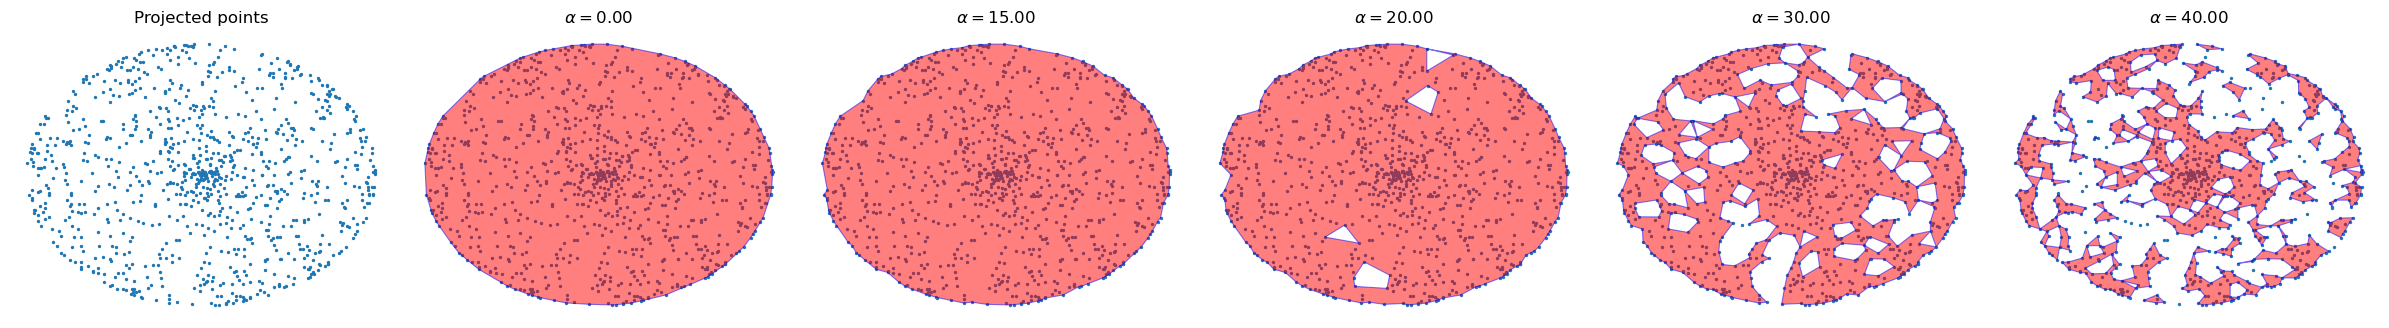

In [16]:
alphas = [0, 10.0, 15, 30, 40]  # List of alphas to try
n = len(alphas)
fig, axes = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 4))

# First panel: raw data
axes[0].scatter(*zip(*points_2d), s=2)
axes[0].set_title("Projected points")
axes[0].set_aspect("equal")
axes[0].axis("off")

# Other panels: alpha shapes
for i, alpha in enumerate(alphas):
    alpha_shape = shaper.get_shape(alpha=alpha)
    ax = axes[i + 1]
    ax.scatter(*zip(*points_2d), s=2)
    plot_alpha_shape(ax, alpha_shape)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_aspect("equal")
    ax.axis("off")

plt.tight_layout()
plt.show()
